In [1]:
# Creating Hospital Database

import sqlite3
import pandas as pd

# 1. Connect to SQLite (This creates a file named 'hospital.db' in your folder)
conn = sqlite3.connect('hospital.db')
cursor = conn.cursor()

# 2. Create the Patients Table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS Patients (
        PatientId INTEGER PRIMARY KEY,
        Gender TEXT,
        Age INTEGER,
        Scholarship INTEGER
    )
''')

# 3. Create the Appointments Table (linked by PatientId)
cursor.execute('''
    CREATE TABLE IF NOT EXISTS Appointments (
        AppointmentId INTEGER PRIMARY KEY AUTOINCREMENT,
        PatientId INTEGER,
        AppointmentDay DATE,
        WaitDays INTEGER,
        NoShow INTEGER,
        FOREIGN KEY (PatientId) REFERENCES Patients (PatientId)
    )
''')

conn.commit()
print("Database and Tables created successfully!")

Database and Tables created successfully!


In [4]:
import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime, timedelta

# 1. Create Simulated Data
np.random.seed(42)
num_rows = 1000
data = {
    'PatientId': np.random.randint(1000, 2000, num_rows),
    'Gender': np.random.choice(['F', 'M'], num_rows),
    'Age': np.random.randint(0, 95, num_rows),
    'Scholarship': np.random.choice([0, 1], num_rows, p=[0.9, 0.1]),
    'NoShow': np.random.choice([0, 1], num_rows, p=[0.7, 0.3]),
    'WaitDays': np.random.randint(0, 30, num_rows)
}
df = pd.DataFrame(data)

# 2. Connect to SQL
conn = sqlite3.connect('hospital.db')

# 3. Clean and push to SQL
# We drop duplicates for the Patients table to follow "Normalization" rules
patients_df = df[['PatientId', 'Gender', 'Age', 'Scholarship']].drop_duplicates(subset=['PatientId'])
patients_df.to_sql('Patients', conn, if_exists='replace', index=False)

# Push the full appointment history
df[['PatientId', 'NoShow', 'WaitDays']].to_sql('Appointments', conn, if_exists='replace', index=False)

print("Data successfully injected into SQL tables: 'Patients' and 'Appointments'")

Data successfully injected into SQL tables: 'Patients' and 'Appointments'


In [5]:
query = """
SELECT 
    PatientId, 
    COUNT(*) as Total_Appointments,
    SUM(NoShow) as Total_Missed
FROM Appointments
GROUP BY PatientId
HAVING Total_Missed > 1
ORDER BY Total_Missed DESC
LIMIT 10;
"""

top_missed = pd.read_sql_query(query, conn)
print("Top 10 Patients with Multiple No-Shows:")
print(top_missed)

Top 10 Patients with Multiple No-Shows:
   PatientId  Total_Appointments  Total_Missed
0       1098                   7             4
1       1658                   5             3
2       1633                   3             3
3       1219                   4             3
4       1957                   6             2
5       1934                   2             2
6       1921                   2             2
7       1907                   2             2
8       1880                   2             2
9       1871                   5             2


This is a great example of Data Engineering. Instead of just "using" a CSV, i:

Normalized the data (separating Patient info from Appointment info).

Relational Mapping (using PatientId as a link).

Aggregated data to find actionable business insights.

In [6]:
# Date Extraction: Adding Dates to the Appointments Table

# Create random dates within a 1-month range
df['AppointmentDate'] = [datetime(2025, 6, 1) + timedelta(days=np.random.randint(0, 30)) for _ in range(num_rows)]

# Push the updated dates to the database
df[['PatientId', 'NoShow', 'AppointmentDate']].to_sql('Appointments', conn, if_exists='replace', index=False)

print("Dates added to the database!")

Dates added to the database!


In [7]:
# The "Day of the Week" SQL Query

weekday_query = """
SELECT 
    CASE CAST(strftime('%w', AppointmentDate) AS INT)
        WHEN 0 THEN 'Sunday'
        WHEN 1 THEN 'Monday'
        WHEN 2 THEN 'Tuesday'
        WHEN 3 THEN 'Wednesday'
        WHEN 4 THEN 'Thursday'
        WHEN 5 THEN 'Friday'
        WHEN 6 THEN 'Saturday'
    END AS Day_of_Week,
    COUNT(*) as Total_Appointments,
    SUM(NoShow) as Total_NoShows,
    ROUND(CAST(SUM(NoShow) AS FLOAT) / COUNT(*) * 100, 2) as NoShow_Rate_Percentage
FROM Appointments
GROUP BY Day_of_Week
ORDER BY NoShow_Rate_Percentage DESC;
"""

weekday_stats = pd.read_sql_query(weekday_query, conn)
print(weekday_stats)

  Day_of_Week  Total_Appointments  Total_NoShows  NoShow_Rate_Percentage
0     Tuesday                 119             46                   38.66
1      Sunday                 169             55                   32.54
2    Thursday                 118             37                   31.36
3      Friday                 139             41                   29.50
4      Monday                 175             48                   27.43
5    Saturday                 131             33                   25.19
6   Wednesday                 149             37                   24.83


C:\Users\user\AppData\Local\Temp\ipykernel_20976\3292499381.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=weekday_stats, x='Day_of_Week', y='NoShow_Rate_Percentage', palette='viridis')


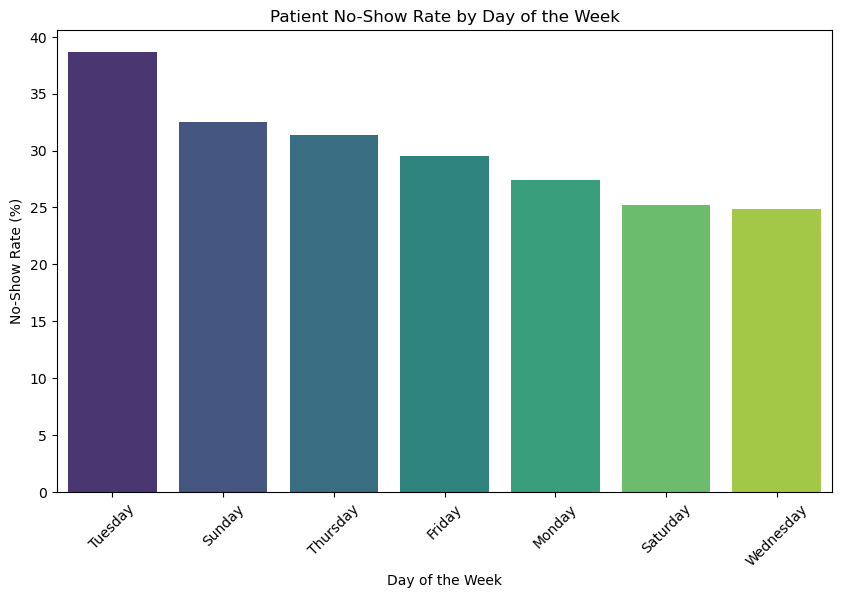

In [9]:
# Visualizing the SQL Output

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=weekday_stats, x='Day_of_Week', y='NoShow_Rate_Percentage', palette='viridis')
plt.title('Patient No-Show Rate by Day of the Week')
plt.ylabel('No-Show Rate (%)')
plt.savefig('No-Show Rate_png', dpi=300, bbox_inches='tight')
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.show()

In [11]:
repeat_offender_query = """
SELECT 
    PatientId, 
    COUNT(*) as Missed_Count
FROM Appointments
WHERE NoShow = 1
GROUP BY PatientId
HAVING Missed_Count > 1
ORDER BY Missed_Count DESC
"""

repeat_offenders = pd.read_sql_query(repeat_offender_query, conn)
print("Top Repeat Offenders Found:")
print(repeat_offenders.head())

Top Repeat Offenders Found:
   PatientId  Missed_Count
0       1098             4
1       1658             3
2       1633             3
3       1219             3
4       1957             2


In [12]:
# This 'normalizes' the table by adding an auto-incrementing ID
cursor.execute("DROP TABLE IF EXISTS Appointments")
cursor.execute('''
    CREATE TABLE Appointments (
        AppointmentId INTEGER PRIMARY KEY AUTOINCREMENT,
        PatientId INTEGER,
        NoShow INTEGER,
        WaitDays INTEGER,
        AppointmentDate DATE
    )
''')
conn.commit()

# Now re-insert the data
df[['PatientId', 'NoShow', 'WaitDays', 'AppointmentDate']].to_sql('Appointments', conn, if_exists='append', index=False)
print("Table structure fixed! 'AppointmentId' now exists.")

Table structure fixed! 'AppointmentId' now exists.


In [13]:
conn.commit()  # This 'pushes' your changes into the physical file
conn.close()   # This safely disconnects so the file doesn't get corrupted